In [101]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from costs import *
from grid_search import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [102]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # least squares: TODO
    # returns mse, and optimal weights
    # ***************************************************
    a=tx.T.dot(tx)
    b=tx.T.dot(y)
    w = np.linalg.solve(a, b) 
    loss=compute_loss(y, tx, w) 
    return w, loss


### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [103]:
from helpers import *
def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # least square or grid search: TODO
    # this code should compare the optimal weights obtained 
    # by least squares vs. grid search
    # ***************************************************
    r=least_squares(y,tx)
    print(r)

Test it here

In [104]:
test_your_least_squares()

(array([73.293922  , 13.47971243]), 15.3858878688294)


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [105]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [106]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # polynomial basis function: TODO
    # this function should return the matrix formed
    # by applying the polynomial basis to the input data
    # ***************************************************
    rx=np.repeat(x,degree)
    for i in range(degree):
        rx[i]=np.power(x,i)
    return rx

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [107]:
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # form the data to do polynomial regression.: TODO
        # ***************************************************
        tx=build_poly(x,degree)
        
        # ***************************************************
        # INSERT YOUR CODE HERE
        # least square and calculate RMSE: TODO
        # ***************************************************
        weights,loss=least_squares(y,tx)
        rmse=np.sqrt(2*calculate_mse(loss))
        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.11133351726547978
Processing 2th experiment, degree=3, rmse=0.03343252619709059
Processing 3th experiment, degree=7, rmse=0.031164734143881594
Processing 4th experiment, degree=12, rmse=0.029615025635382396


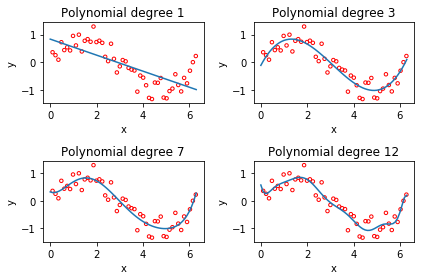

In [108]:
polynomial_regression()

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [115]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio i$s 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data based on the given ratio: TODO
    # ***************************************************
    indices = np.random.permutation(len(y))
    index_split=int(np.ceil(len(y)*ratio))
    index_tr = indices[: index_split]
    index_te = indices[index_split:]
    x_tr = x[index_tr]
    x_te = x[index_te]
    y_tr = y[index_tr]
    y_te = y[index_te]
    return x_tr, x_te, y_tr, y_te

Then, test your `split_data` function below.

In [118]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data, and return train and test data: TODO
    # ***************************************************
    trainx,trainy,testx,testy=split_data(x,y,ratio)
    
        # ***************************************************
    # INSERT YOUR CODE HERE
    # form train and test data with polynomial basis function: TODO
    # ***************************************************
    trainx=build_poly(trainx,7)
    testx=build_poly(testx,7)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calcualte weight through least square.: TODO
    # ***************************************************
    weightstrain,losstrai=least_squares(trainy,trainx)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate RMSE for train and test data,
    # and store them in rmse_tr and rmse_te respectively: TODO
    # ***************************************************
    rmse_tr=np.sqrt(2*calculate_mse(losstrain))
    rmse_te=np.sqrt(2*calculate_mse(losstest))
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))

In [119]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

ValueError: shapes (8,45) and (5,) not aligned: 45 (dim 1) != 5 (dim 0)

# 3 Ridge Regression
Please fill in the function below.

In [ ]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # ridge regression: TODO
    # ***************************************************
    raise NotImplementedError

In [ ]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data, and return train and test data: TODO
    # ***************************************************
    raise NotImplementedError
    # ***************************************************
    # INSERT YOUR CODE HERE
    # form train and test data with polynomial basis function: TODO
    # ***************************************************
    raise NotImplementedError

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # ridge regression with a given lambda
        # ***************************************************
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

    raise NotImplementedError


In [ ]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)